In [0]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import gensim
import nltk
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
%matplotlib inline

In [140]:
#read in file
df = pd.read_csv('quiz1.csv')
df = df[pd.notnull(df['Rating'])]
print(df.head(10))

    ID  Rating                                           Response
0   JA       2  R2 and R3 are in parallel so the voltage drop ...
1  WCA       2  Vs is an ideal component, so changing R2 will ...
2   AA       1  First count the node and see what we have on p...
3   RA       2  Since R2 decreases that means more current wil...
4   AB       1  If the resistance of R2 decreases the power as...
5   KB       2  All of the current from Vs goes through R1 and...
6   JB       2  I would start this problem by examining the ca...
7   BB       2  Since the resistance of R2 goes down, more cur...
8   JB       3  When the resistance is lower, the current incr...
9   NB       2  As R2 decreases, voltage stays the same, so I2...


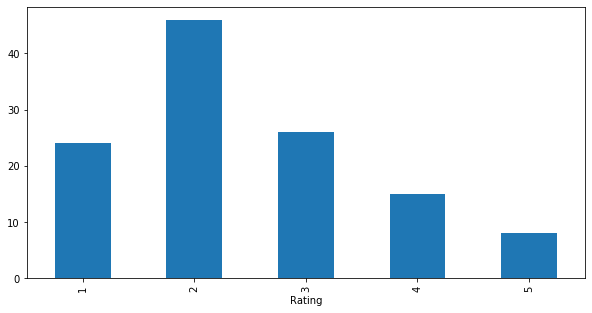

In [141]:
#plot number of responses per rating
ratings = ['1','2','3','4','5']
plt.figure(figsize=(10,5))
df.groupby('Rating').Response.count().plot.bar(ylim=0)
plt.show()

In [142]:
print('Total Words in Response before pre-processing:',df['Response'].apply(lambda x: len(x.split(' '))).sum())

Total Words in Response before pre-processing: 10379


In [143]:
#read thru csv to see what text looks like before preprocessing
def print_plot(index):
    sample = df[df.index == index][['Response', 'Rating']].values[0]
    if len(sample) > 0:
        print(sample[0])
        print('Rating:', sample[1])
print_plot(0)

R2 and R3 are in parallel so the voltage drop across each is equal but the current is not.  Then if I knew values I would calculate the new equivalent resistance between them, then R23 plus R1 because they are in series.  The I would use Ohmís law to find the new current in the circuit using voltage equals current times resistance.  I know all the elements are ideal and how resistor behave in parallel and in series, I also know Vs, R1 and R3 remain unchanged.  The next thing I would do is power equals current times voltage and because all resistors dissipate power, I would know Vs has to supply power.  At first glance, without doing any math, you could assume that a greater portion of the current entering into the node would go through R2 because itíd take the path of least resistance.  going back to calculating power I would also use power equals current squared times resistance so I wouldnít need voltage, but it would be useful to finding current so I would still use it.
Rating: 2


In [144]:
#preprocessing
nltk.download('stopwords') 
replace_space = re.compile('[/(){}\[\]\|@,;]') 
bad_symbol = re.compile('[^0-9a-z #+_]')
stopword = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() #make all text lower case
    text = replace_space.sub(' ', text) #replace symbols with space
    text = bad_symbol.sub('', text) #remove bad symbols
    text = ' '.join(word for word in text.split() if word not in stopword) #remove stopwords
    return text
    
df['Response'] = df['Response'].apply(clean_text) #apply clean text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [145]:
#print pre processed data sample
print_plot(0)

r2 r3 parallel voltage drop across equal current knew values would calculate new equivalent resistance r23 plus r1 series would use ohms law find new current circuit using voltage equals current times resistance know elements ideal resistor behave parallel series also know vs r1 r3 remain unchanged next thing would power equals current times voltage resistors dissipate power would know vs supply power first glance without math could assume greater portion current entering node would go r2 itd take path least resistance going back calculating power would also use power equals current squared times resistance wouldnt need voltage would useful finding current would still use
Rating: 2


In [146]:
print('Total Words after pre-processing:',df['Response'].apply(lambda x: len(x.split(' '))).sum())

Total Words after pre-processing: 5627


In [147]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Response).toarray()
labels = df.Rating
features.shape

(119, 268)

In [0]:
#create train test set. test size set to 0.5 for 2-fold cross validation
X = df.Response
Y = df.Rating
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

vect = CountVectorizer()
X_train_counts = vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [150]:
#MultinomialNB 
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#pipelining data vectorize -> transform -> classifier/predict 
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

print('Multinomial Naive Bayes')
print('Accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=ratings))


Multinomial Naive Bayes
Accuracy 0.38333333333333336
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        16
           2       0.37      1.00      0.54        22
           3       1.00      0.09      0.17        11
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00         3

    accuracy                           0.38        60
   macro avg       0.27      0.22      0.14        60
weighted avg       0.32      0.38      0.23        60



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [151]:
#predict rating for random response 
clf = MultinomialNB().fit(X_train_tfidf, y_train)
print('Predicted Rating:',clf.predict(vect.transform(["The equivalent resistance of the circuit is R1 plus the parallel combination of R2 and R3. As R2 decreases in resistance the R23 parallel combination will also decrease. Lower resistance means higher conductance, and therefore Req becomes lower. As Req lowers, more curernt is allowed through the circuit, and the power absorbed by the resistors increases. The power supplied by Vs also increases, and energy is conserved."])))

Predicted Rating: [2]


In [154]:
#Linear SVM
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

print('Linear Support Vector Machine')
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=ratings))

Linear Support Vector Machine
accuracy 0.35
              precision    recall  f1-score   support

           1       0.46      0.38      0.41        16
           2       0.36      0.45      0.40        22
           3       0.38      0.27      0.32        11
           4       0.22      0.25      0.24         8
           5       0.00      0.00      0.00         3

    accuracy                           0.35        60
   macro avg       0.28      0.27      0.27        60
weighted avg       0.35      0.35      0.35        60



In [155]:
#predict rating for random response 
clf = SGDClassifier().fit(X_train_tfidf, y_train)
print('Predicted Rating:',clf.predict(vect.transform(["The equivalent resistance of the circuit is R1 plus the parallel combination of R2 and R3. As R2 decreases in resistance the R23 parallel combination will also decrease. Lower resistance means higher conductance, and therefore Req becomes lower. As Req lowers, more curernt is allowed through the circuit, and the power absorbed by the resistors increases. The power supplied by Vs also increases, and energy is conserved."])))

Predicted Rating: [4]


In [156]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(random_state=0)),
               ])

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Logistic Regression')
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=ratings))

Logistic Regression
accuracy 0.38333333333333336
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        16
           2       0.37      0.91      0.53        22
           3       0.50      0.27      0.35        11
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00         3

    accuracy                           0.38        60
   macro avg       0.17      0.24      0.18        60
weighted avg       0.23      0.38      0.26        60



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [157]:
#predict rating for random response 
clf = LogisticRegression().fit(X_train_tfidf, y_train)
print('Predicted Rating:',clf.predict(vect.transform(["The equivalent resistance of the circuit is R1 plus the parallel combination of R2 and R3. As R2 decreases in resistance the R23 parallel combination will also decrease. Lower resistance means higher conductance, and therefore Req becomes lower. As Req lowers, more curernt is allowed through the circuit, and the power absorbed by the resistors increases. The power supplied by Vs also increases, and energy is conserved."])))

Predicted Rating: [4]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [158]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rfc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)),
                 ])

rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print('Random Forest Classifier')
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=ratings))

Random Forest Classifier
accuracy 0.38333333333333336
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        16
           2       0.37      1.00      0.54        22
           3       1.00      0.09      0.17        11
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00         3

    accuracy                           0.38        60
   macro avg       0.27      0.22      0.14        60
weighted avg       0.32      0.38      0.23        60



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [159]:
#predict rating for random response 
clf = RandomForestClassifier().fit(X_train_tfidf, y_train)
print('Predicted Rating:',clf.predict(vect.transform(["The equivalent resistance of the circuit is R1 plus the parallel combination of R2 and R3. As R2 decreases in resistance the R23 parallel combination will also decrease. Lower resistance means higher conductance, and therefore Req becomes lower. As Req lowers, more curernt is allowed through the circuit, and the power absorbed by the resistors increases. The power supplied by Vs also increases, and energy is conserved."])))

Predicted Rating: [4]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [160]:
#plot data using seaborn
import seaborn as sns
from sklearn.model_selection import cross_val_score

models = [
          MultinomialNB(),
          LogisticRegression(random_state=0),
          RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
          SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracy = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracy):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['classifier', 'fold_idx', 'accuracy'])


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

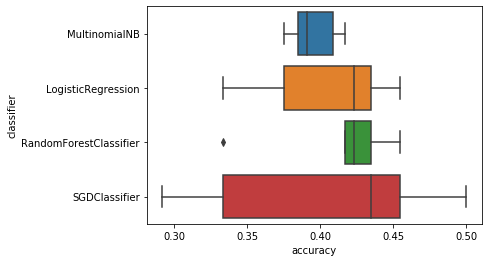

In [161]:
plot = sns.boxplot(x="accuracy", y="classifier", data=cv_df)